In [1]:
#!/usr/bin/env python3
import re
import matplotlib
import glob
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

matplotlib.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [2]:
def preprocess_df(data_dir, sample):
    matrix_file = glob.glob(data_dir + '/*' + sample + '*200*50*matrix.csv')
    if len(matrix_file) == 1:
        df = pd.read_csv(matrix_file[0],
                         index_col=0,
                         sep='\t',             
                         header=None)
    else:
        print("Sample file is not unique.")
    
    r, c = df.shape
    if c % 2 == 0:
        mid_bin = c / 2
    else:
        mid_bin = round(c / 2)

    sum_left_bin = int(mid_bin-int(c*.1))
    sum_right_bin = int(mid_bin+int(c*.1))

    df.columns = [sample + '_bin_' + str(i) for i in range(0, c)]
    sum_string = sample + '_sum'
    df[sum_string] = np.sum(df.iloc[:,sum_left_bin:sum_right_bin], axis=1)

    return df

In [3]:
data_dir = 'ENCODE_heatmap'

p300_df  = preprocess_df(data_dir, 'EP300-2')
K27ac_df = preprocess_df(data_dir, 'H3K27ac-2')
K4me3_df = preprocess_df(data_dir, 'H3K4me3-2')
DNase_df = preprocess_df(data_dir, 'DNase')

df = pd.concat([p300_df, K27ac_df, K4me3_df, DNase_df], axis=1)

index_fix = []
for i in df.index:
    chrom, l, r = i.split('_')
    index_fix.append(chrom + ':' + l + '-' + r)
df.index = index_fix

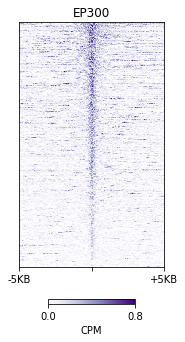

In [4]:
fig = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(nrows=1, ncols=15)

#plot p300
ax1 = fig.add_subplot(gs[:,0:5])
p300_col = [i for i in df.columns if 'EP300-2_bin' in i]
hm1 = ax1.imshow(df.sort_values(by='EP300-2_sum', ascending=True)[p300_col],
                        origin='lower',
                        cmap=plt.cm.Purples,
                        vmin=0,
                        vmax=0.8,
                        aspect='auto')

xmin, xmax = ax1.get_xlim()                        
ax1.set_xticks([xmin, (xmax-xmin)/2, xmax])
ax1.set_xticklabels(['-5KB', '', '+5KB'])
ax1.set_title('EP300')
ax1.set_yticks([], [])

plt.colorbar(hm1, 
            orientation='horizontal',
            pad=0.1,
            shrink=0.6,
            ticks=[0,0.8],
            label='CPM')

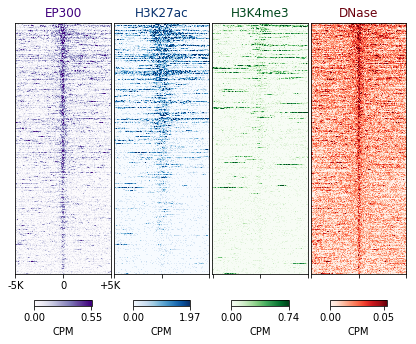

In [5]:
fig = plt.figure(figsize=(7,6))
gs = gridspec.GridSpec(nrows=1, ncols=20)

df_sorted = df.sort_values(by=['DNase_sum', 'EP300-2_sum'], ascending=True)
color_map = [plt.cm.Purples, plt.cm.Blues, plt.cm.Greens, plt.cm.Reds]

#plot all the features
for i, feature in enumerate(['EP300-2', 'H3K27ac-2', 'H3K4me3-2', 'DNase',]):

    ax = fig.add_subplot(gs[:, (i*5):(i*5+5)])
    select_col = [i for i in df.columns if (feature + '_bin') in i]

    #define the heatmap range    
    vmin = 0
    vmax = np.max(df_sorted[select_col].values)*0.7

    hm = ax.imshow(df_sorted[select_col],
                    origin='lower',
                    cmap=color_map[i],
                    vmin=vmin,
                    vmax=vmax,
                    aspect='auto')
    
    ax.set_title(feature.split('-')[0], color=color_map[i](0.99))
    ax.set_xticklabels([])
    ax.set_yticks([], [])

    plt.colorbar(hm, 
                orientation='horizontal',
                pad=0.08,
                shrink=0.6,
                aspect=10,
                ticks=[int(vmin), round(vmax, 2)],
                label='CPM')

    ax = fig.get_axes()[0]
    xmin, xmax = ax.get_xlim()              
    ax.set_xticks([xmin, (xmax-xmin)/2, xmax])
    ax.set_xticklabels(['-5K', '0', '+5K'])

fig.savefig('Heatmap_allmarkers_200X50.png', dpi=200)